# Stable Diffusion 2D Optimization Demo
This notebook runs the 2D optimization script using the custom diffusion logic from `run2d.py` and `utils.py`.

In [5]:
# Install required packages (uncomment if needed)
# !pip install diffusers pytorch_wavelets transformers accelerate


In [7]:
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from dc.utils_ import load_512, get_text_embeddings, denormalize, decode, init_pipe


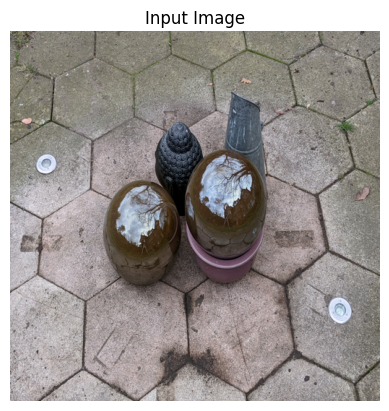

In [9]:
# Load an image and preprocess
image_path = "trial.jpg"  # <-- Replace with your actual image path
image_np = load_512(image_path)
image = Image.fromarray(image_np)
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()


In [11]:
# Standard library imports
import os
import datetime
import time
from typing import List, Optional, Tuple, Union
from collections import defaultdict

# Third-party imports
import numpy as np
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from torch.optim.sgd import SGD
from tqdm import tqdm

# Local application imports
from dc.utils_ import load_512, get_text_embeddings, denormalize, decode, init_pipe

# Type aliases
T = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

# Constants
V1_4_RGB_LATENT_FACTORS = [
    #   R       G       B
    [ 0.298,  0.207,  0.208],  # L1
    [ 0.187,  0.286,  0.173],  # L2
    [-0.158,  0.189,  0.264],  # L3
    [-0.184, -0.271, -0.473],  # L4
]

# Device setup with fallback
assert torch.cuda.is_available(), "CUDA not available, using CPU (this will be very slow)"
device = torch.device('cuda:0')

# Performance tracking
perf_stats = defaultdict(float)
perf_counts = defaultdict(int)

def track_time(category):
    """Decorator to track execution time of functions"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Check if the first argument is the image_optimization function
            # and if it has a 'profiling_enabled' attribute
            profiling_enabled = False
            if args and hasattr(args[0], 'profiling_enabled'):
                profiling_enabled = args[0].profiling_enabled
            
            if not profiling_enabled:
                return func(*args, **kwargs)
                
            start_time = time.time()
            result = func(*args, **kwargs)
            elapsed = time.time() - start_time
            perf_stats[category] += elapsed
            perf_counts[category] += 1
            return result
        return wrapper
    return decorator

def print_performance_report(enabled=True):
    """Print a summary of performance metrics"""
    if not enabled:
        return
        
    print("\n" + "="*50)
    print("PERFORMANCE REPORT")
    print("="*50)
    total_time = sum(perf_stats.values())
    
    # Sort categories by total time (descending)
    sorted_categories = sorted(perf_stats.keys(), key=lambda x: perf_stats[x], reverse=True)
    
    print(f"{'Category':<30} {'Total Time (s)':<15} {'Calls':<10} {'Avg Time (s)':<15} {'% of Total':<15}")
    print("-"*85)
    
    for category in sorted_categories:
        avg_time = perf_stats[category] / perf_counts[category] if perf_counts[category] > 0 else 0
        percentage = (perf_stats[category] / total_time * 100) if total_time > 0 else 0
        print(f"{category:<30} {perf_stats[category]:<15.3f} {perf_counts[category]:<10} {avg_time:<15.3f} {percentage:<15.2f}%")
    
    print("="*50)
    print(f"Total tracked time: {total_time:.3f} seconds")
    print("="*50)

class DDSLoss:

    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device, dtype=torch.long)
        
        if eps is None:
            eps = torch.randn_like(z)
        
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        
        z_t = alpha_t * z + sigma_t * eps

        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(self, 
                            z_t: T, 
                            timestep: T, 
                            text_embeddings: T, 
                            alpha_t: T, 
                            sigma_t: T, 
                            get_raw=False,
                            guidance_scale=7.5):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(-1, *text_embeddings.shape[2:])
        
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == 'v_prediction':
                e_t = torch.cat([alpha_t] * 2) * e_t + torch.cat([sigma_t] * 2) * latent_input
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        
        if get_raw:
            return e_t
        
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        
        return e_t, pred_z0

    def get_sds_loss(self, 
                z: T, 
                text_embeddings: T, 
                eps: TN = None, 
                mask=None, 
                t=None,
                timestep: Optional[int] = None, 
                guidance_scale=7.5) -> TS:
        
        with torch.inference_mode():
            
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(z, 
                                                        eps=eps, 
                                                        timestep=timestep)
            
            e_t, _ = self.get_eps_prediction(z_t, 
                                            timestep, 
                                            text_embeddings, 
                                            alpha_t, 
                                            sigma_t,
                                            guidance_scale=guidance_scale)
            
            grad_z = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (e_t - eps)
            
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z ** 2).mean()
        
        sds_loss = grad_z.clone() * z

        del grad_z

        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss

    def get_dds_loss(self, 
                    z_source: T, 
                    z_target: T, 
                    text_emb_source: T, 
                    text_emb_target: T,
                    eps=None, 
                    reduction='mean', 
                    symmetric: bool = False, 
                    calibration_grad=None, 
                    timestep: Optional[int] = None,
                    guidance_scale=7.5, 
                    raw_log=False) -> TS:
        
        with torch.inference_mode():
            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(z_source, eps, timestep)
            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            
            eps_pred, _ = self.get_eps_prediction(torch.cat((z_t_source, z_t_target)),
                                                  torch.cat((timestep, timestep)),
                                                  torch.cat((text_emb_source, text_emb_target)),
                                                  torch.cat((alpha_t, alpha_t)),
                                                  torch.cat((sigma_t, sigma_t)),
                                                  guidance_scale=guidance_scale)
            
            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (eps_pred_target - eps_pred_source)
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = eps.detach().cpu(), eps_pred_target.detach().cpu(), eps_pred_source.detach().cpu()
            else:
                log_loss = (grad ** 2).mean()

        loss = z_target * grad.clone()

        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == 'mean':
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        
        return loss, log_loss, grad
    
    def get_dwt_dds_loss(self, 
                z_source: T, 
                text_emb_source: T, 
                text_emb_target: T, 
                idwt:T, 
                dwt_latent: T,
                eps=None, 
                reduction='mean', 
                symmetric: bool = False, 
                calibration_grad=None, 
                timestep: Optional[int] = None,
                guidance_scale=7.5, 
                raw_log=False) -> TS:
        
        z_target = idwt((dwt_latent[0], dwt_latent[1:]))
        
        z_target = z_target.requires_grad_(True)
        
        with torch.inference_mode():

            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(z_source, eps, timestep)

            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            
            eps_pred, _ = self.get_eps_prediction(torch.cat((z_t_source, z_t_target)),
                                                  torch.cat((timestep, timestep)),
                                                  torch.cat((text_emb_source, text_emb_target)),
                                                  torch.cat((alpha_t, alpha_t)),
                                                  torch.cat((sigma_t, sigma_t)),
                                                  guidance_scale=guidance_scale)

            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (eps_pred_target - eps_pred_source)
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = eps.detach().cpu(), eps_pred_target.detach().cpu(), eps_pred_source.detach().cpu()
            else:
                log_loss = (grad ** 2).mean()

        loss = z_target * grad.clone()

        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == 'mean':
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        return loss, log_loss, z_target, grad

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(device, dtype, pipe.unet, pipe.scheduler)
        self.prediction_type = pipe.scheduler.prediction_type

@track_time("Vis")
def visualize_optimization_step(i, vis_method, vis_decode_dir, vis_linear_dir, 
                               z_target, pipe, image, grad=None, dwt_dds=False, 
                               params=None, wavelet="db3", J=5, 
                               accumulated_rgb_low=None, accumulated_rgb_high=None):
    """
    Generate and save visualizations for the current optimization step.
    """
    # Define performance tracking for sub-components
    vis_perf = {}
    
    def time_component(name):
        """Simple context manager to time components within the visualization function"""
        class TimerContext:
            def __enter__(self):
                self.start_time = time.time()
                return self
            
            def __exit__(self, *args):
                elapsed = time.time() - self.start_time
                if name in vis_perf:
                    vis_perf[name] += elapsed
                else:
                    vis_perf[name] = elapsed
                # Also add to global performance stats with shorter names
                if f"Vis:{name}" in perf_stats:
                    perf_stats[f"Vis:{name}"] += elapsed
                    perf_counts[f"Vis:{name}"] += 1
                else:
                    perf_stats[f"Vis:{name}"] = elapsed
                    perf_counts[f"Vis:{name}"] = 1
        
        return TimerContext()
    
    # Define latent_to_rgb function 
    with time_component("Setup"):
        def latent_to_rgb(latent):
            rgb = torch.zeros(latent.shape[0], 3, latent.shape[2], latent.shape[3], device=latent.device)
            for i in range(4):
                for j in range(3):  # RGB channels
                    rgb[:, j] += latent[:, i] * V1_4_RGB_LATENT_FACTORS[i][j]
            return rgb
    
    # Generate decode visualizations
    if vis_method == "decode" or vis_method == "both":
        with time_component("Dec:PrepGrad"):
            # Visualize gradients for each level
            grads = [-i.grad for i in params if i.grad is not None] if dwt_dds else []

            if dwt_dds:
                # Assuming the first gradient is for Yl (low-frequency) and the rest are for Yh (high-frequency)
                Yl_grad = grads[0]
                Yh_grads = grads[1:]

                # Get current wavelet coefficients (not gradients)
                current_coeffs = [param.detach() for param in params]
                Yl_current = current_coeffs[0]
                Yh_current = current_coeffs[1:]

                wave = wavelet
                J = len(Yh_grads)
                
                with time_component("Dec:DWTCreate"):
                    dwt_vis = DWTForward(J=J, wave=wave, mode='zero').cuda()
                    idwt_vis = DWTInverse(wave=wave, mode='zero').cuda()
            
        with time_component("Dec:CreateVis"):
            # Create a list to store all visualization images
            all_vis_images = []
            
            # Add original image for reference
            with time_component("Dec:OrigImg"):
                original_image = Image.fromarray(image.astype(np.uint8))
                all_vis_images.append(original_image)
            
            # Add current result
            with time_component("Dec:CurrRes"):
                decoded_current = decode(z_target, pipe)
                all_vis_images.append(decoded_current)
            
            if dwt_dds:
                # Visualize low-frequency gradient
                with time_component("Dec:LowFreqGrad"):
                    Yl_masked = Yl_grad.clone()
                    Yh_zeros = [torch.zeros_like(Yh) for Yh in Yh_grads]
                    reconstructed_low = idwt_vis((Yl_masked, Yh_zeros))
                    low_freq_image = decode(reconstructed_low, pipe)
                    all_vis_images.append(low_freq_image)

                # Visualize each high-frequency level's gradient
                with time_component("Dec:HighFreqGrad"):
                    for level in range(J):
                        Yl_zero = torch.zeros_like(Yl_grad)
                        Yh_masked = [torch.zeros_like(Yh) for Yh in Yh_grads]
                        Yh_masked[level] = Yh_grads[level].clone()
                        reconstructed_high = idwt_vis((Yl_zero, Yh_masked))
                        high_freq_image = decode(reconstructed_high, pipe)
                        all_vis_images.append(high_freq_image)
                
                # Visualize low-frequency current coefficient
                with time_component("Dec:LowFreqCoef"):
                    Yl_coeff_masked = Yl_current.clone()
                    Yh_coeff_zeros = [torch.zeros_like(Yh) for Yh in Yh_current]
                    recon_low_coeff = idwt_vis((Yl_coeff_masked, Yh_coeff_zeros))
                    low_coeff_image = decode(recon_low_coeff, pipe)
                    all_vis_images.append(low_coeff_image)
                
                # Visualize each high-frequency level's current coefficient
                with time_component("Dec:HighFreqCoef"):
                    for level in range(J):
                        Yl_coeff_zero = torch.zeros_like(Yl_current)
                        Yh_coeff_masked = [torch.zeros_like(Yh) for Yh in Yh_current]
                        Yh_coeff_masked[level] = Yh_current[level].clone()
                        recon_high_coeff = idwt_vis((Yl_coeff_zero, Yh_coeff_masked))
                        high_coeff_image = decode(recon_high_coeff, pipe)
                        all_vis_images.append(high_coeff_image)
                
                # Visualize full reconstruction from all coefficients
                with time_component("Dec:FullRecon"):
                    full_recon = idwt_vis((Yl_current, Yh_current))
                    full_image = decode(full_recon, pipe)
                    all_vis_images.append(full_image)
        
        with time_component("Dec:Combine"):
            # Create combined image (1xN)
            padding = 5
            combined_width = (512 + padding) * len(all_vis_images) - padding
            combined_height = 512
            
            # Adding text labels to indicate what each part represents
            labels = ["Original", "Current Result", "Low Freq Grad"]
            for level in range(J):
                labels.append(f"High Freq Grad L{level+1}")
            labels.append("Low Freq Coeff")
            for level in range(J):
                labels.append(f"High Freq Coeff L{level+1}")
            labels.append("Full Recon")
            
            # Create image with labels
            font_size = 24

            from PIL import ImageDraw, ImageFont
            labeled_image = Image.new('RGB', (combined_width, combined_height + 30), color='white')
            
            # Paste all images horizontally
            x_offset = 0
            for img in all_vis_images:
                labeled_image.paste(img, (x_offset, 0))
                x_offset += img.width + padding
                
            draw = ImageDraw.Draw(labeled_image)

            font = ImageFont.truetype("assets/Arial.ttf", font_size)
            
            x_offset = 0
            for idx, label in enumerate(labels):
                # Center the text under each image
                text_width = font.getsize(label)[0] if hasattr(font, 'getsize') else draw.textlength(label, font)
                text_x = x_offset + (512 - text_width) // 2
                draw.text((text_x, combined_height + 5), label, fill="black", font=font)
                x_offset += 512 + padding
            
            # Track saving time separately
            start_save_time = time.time()
            labeled_image.save(os.path.join(vis_decode_dir, f"decoded_step_{i+1}.png"))
            perf_stats["Save:DecodeImg"] += time.time() - start_save_time
            perf_counts["Save:DecodeImg"] += 1
            
    # Generate linear visualizations
    if vis_method == "linear" or vis_method == "both":
        
        if not dwt_dds:
            with time_component("Lin:NonDWT"):
                # Decode the current z_target - without im_cat to get 512x512
                decoded_image = decode(z_target, pipe)
                
                # For reference, include the original image separately
                original_image = Image.fromarray(image.astype(np.uint8))
                
                # visualize the grad
                grad_vis = - grad.detach().cpu()
                grad_rgb = latent_to_rgb(grad_vis)
                
                # Normalize
                grad_rgb = grad_rgb - grad_rgb.min()
                grad_rgb = grad_rgb / (grad_rgb.max() + 1e-8)
                
                grad_image = Image.fromarray((grad_rgb[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
                grad_image = grad_image.resize((512, 512), Image.NEAREST)

                # put three images in a row
                combined_image = Image.new('RGB', (1536, 512), color='white')
                combined_image.paste(original_image, (0, 0))
                combined_image.paste(decoded_image, (512, 0))
                combined_image.paste(grad_image, (1024, 0))
            
            with time_component("Lin:NonDWTSave"):
                combined_image.save(os.path.join(vis_linear_dir, f"visualizations_step_{i+1}.png"))
            
        elif dwt_dds:
            with time_component("Lin:DWTSetup"):
                # Get current wavelet coefficients (not gradients)
                current_coeffs = [param.detach() for param in params]
                Yl_current = current_coeffs[0]
                Yh_current = current_coeffs[1:]

                # Get gradients (existing code)
                grads = [-i.grad for i in params if i.grad is not None]
                Yl_grad = grads[0]
                Yh_grads = grads[1:]

                wave = wavelet
                J = len(Yh_grads)
                dwt_vis = DWTForward(J=J, wave=wave, mode='zero').cuda()
                idwt_vis = DWTInverse(wave=wave, mode='zero').cuda()

            with time_component("Lin:CurrVis"):
                # Lists to store current and accumulated visualizations
                current_visualizations = []
                accumulated_visualizations = []
                
                # accumulated_rgb_low += rgb_low
                if accumulated_rgb_low is None:
                    accumulated_rgb_low = Yl_grad
                else:
                    accumulated_rgb_low += Yl_grad

                if accumulated_rgb_high is None:
                    accumulated_rgb_high = []
                    for level in range(J):
                        accumulated_rgb_high.append(Yh_grads[level])
                else:
                    for level in range(J):
                        accumulated_rgb_high[level] += Yh_grads[level]

                # Prepare tensors for all levels (including low frequency)
                all_current_tensors = []
                for level in range(J):
                    Yl_zero = torch.zeros_like(Yl_grad)
                    Yh_masked = [torch.zeros_like(Yh) for Yh in Yh_grads]
                    Yh_masked[level] = Yh_grads[level].clone()
                    reconstructed_high = idwt_vis((Yl_zero, Yh_masked))
                    rgb_high = latent_to_rgb(reconstructed_high)
                    all_current_tensors.append(rgb_high)

                # Add low frequency gradient tensor
                all_current_tensors.append(latent_to_rgb(idwt_vis((Yl_grad, [torch.zeros_like(Yh) for Yh in Yh_grads]))))

                # Find global min and max for normalization
                all_current = torch.cat(all_current_tensors, dim=0)
                global_min = all_current.min()
                global_max = all_current.max()

                # Normalize and create images
                current_visualizations = []
                for tensor in all_current_tensors:
                    norm_rgb = (tensor - global_min) / (global_max - global_min)
                    current_image = Image.fromarray((norm_rgb[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
                    current_image = current_image.resize((512, 512), Image.NEAREST)
                    current_visualizations.append(current_image)

            with time_component("Lin:AccumVis"):
                # Accumulated gradient visualization
                all_accumulated_tensors = []
                for level in range(J):
                    Yl_zero_acc = torch.zeros_like(Yl_grad)
                    Yh_masked_acc = [torch.zeros_like(Yh) for Yh in Yh_grads]
                    Yh_masked_acc[level] = accumulated_rgb_high[level].clone()
                    reconstructed_high_acc = idwt_vis((Yl_zero_acc, Yh_masked_acc))
                    rgb_high_acc = latent_to_rgb(reconstructed_high_acc)
                    all_accumulated_tensors.append(rgb_high_acc)

                # Add low frequency gradient tensor
                all_accumulated_tensors.append(latent_to_rgb(idwt_vis((accumulated_rgb_low, [torch.zeros_like(Yh) for Yh in Yh_grads]))))

                # Find global min and max for normalization
                all_accumulated = torch.cat(all_accumulated_tensors, dim=0)
                global_min = all_accumulated.min()
                global_max = all_accumulated.max()

                # Normalize and create images
                accumulated_visualizations = []
                for tensor in all_accumulated_tensors:
                    norm_acc_rgb = (tensor - global_min) / (global_max - global_min)
                    accumulated_image = Image.fromarray((norm_acc_rgb[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
                    accumulated_image = accumulated_image.resize((512, 512), Image.NEAREST)
                    accumulated_visualizations.append(accumulated_image)

            with time_component("Lin:WaveletVis"):
                # Add visualization for current wavelet coefficients
                all_current_wavelet_tensors = []
                for level in range(J):
                    Yl_zero = torch.zeros_like(Yl_current)
                    Yh_masked = [torch.zeros_like(Yh) for Yh in Yh_current]
                    Yh_masked[level] = Yh_current[level].clone()
                    reconstructed_wavelet = idwt_vis((Yl_zero, Yh_masked))
                    rgb_wavelet = latent_to_rgb(reconstructed_wavelet)
                    all_current_wavelet_tensors.append(rgb_wavelet)

                # Add low frequency wavelet tensor
                all_current_wavelet_tensors.append(latent_to_rgb(idwt_vis((Yl_current, [torch.zeros_like(Yh) for Yh in Yh_current]))))

                # Normalize and create images for wavelet coefficients
                all_wavelets = torch.cat(all_current_wavelet_tensors, dim=0)
                wavelet_min = all_wavelets.min()
                wavelet_max = all_wavelets.max()

                wavelet_visualizations = []
                for tensor in all_current_wavelet_tensors:
                    norm_wavelet = (tensor - wavelet_min) / (wavelet_max - wavelet_min)
                    wavelet_image = Image.fromarray((norm_wavelet[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
                    wavelet_image = wavelet_image.resize((512, 512), Image.NEAREST)
                    wavelet_visualizations.append(wavelet_image)

            with time_component("Lin:FinalImg"):
                # Decode the current z_target - WITHOUT im_cat to get 512x512
                decoded_image = decode(z_target, pipe)
                
                # Original image for comparison
                original_image = Image.fromarray(image.astype(np.uint8))

                # Convert grad tensor to RGB visualization using the same function
                grad_vis = - grad.detach().cpu()
                grad_rgb = latent_to_rgb(grad_vis)
                
                # Normalize
                grad_rgb = grad_rgb - grad_rgb.min()
                grad_rgb = grad_rgb / (grad_rgb.max() + 1e-8)
                
                grad_image = Image.fromarray((grad_rgb[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
                grad_image = grad_image.resize((512, 512), Image.NEAREST)

                # Set padding
                padding = 5

                # Calculate dimensions for the combined image (now including grad visualization)
                num_vis = len(current_visualizations)
                vis_width = (512 + padding) * (2 + 1 + num_vis * 2) + padding  # Original, current, grad, and all wavelet visualizations
                vis_height = 512 + 30  # Add space for text labels

                # Create combined image (white background)
                combined_image = Image.new('RGB', (vis_width, vis_height), color='white')

                # Paste original image first
                combined_image.paste(original_image, (0, 0))
                x_offset = 512 + padding
                
                # Paste the decoded image 
                combined_image.paste(decoded_image, (x_offset, 0))
                x_offset += 512 + padding
                
                # Paste the gradient visualization 
                combined_image.paste(grad_image, (x_offset, 0))
                x_offset += 512 + padding
                
                # Paste the wavelet visualizations (current coefficients)
                for img in wavelet_visualizations:
                    combined_image.paste(img, (x_offset, 0))
                    x_offset += img.width + padding
                    
                # Paste current wavelet visualizations
                for img in current_visualizations:
                    combined_image.paste(img, (x_offset, 0))
                    x_offset += img.width + padding

                # Paste accumulated visualizations (A_low, A_1, A_2, ...)
                for img in accumulated_visualizations:
                    combined_image.paste(img, (x_offset, 0))
                    x_offset += img.width + padding
                
                # Add text labels

                from PIL import ImageDraw, ImageFont
                draw = ImageDraw.Draw(combined_image)
                
                font = ImageFont.truetype("assets/Arial.ttf", 24)
                
                # Define labels
                labels = ["Original Image", "Current Result", "Gradient"]
                
                # Add wavelet coefficient labels
                for level in range(J):
                    labels.append(f"Coef Level {level+1}")
                labels.append("Coef Low Freq")
                
                # Add current wavelet gradient labels
                for level in range(J):
                    labels.append(f"Curr Grad Level {level+1}")
                labels.append("Curr Grad Low Freq")
                
                # Add accumulated gradient labels
                for level in range(J):
                    labels.append(f"Accum Grad Level {level+1}")
                labels.append("Accum Grad Low Freq")
                
                # Draw labels
                x_offset = 0
                for idx, label in enumerate(labels):
                    # Center the text under each image
                    text_width = font.getsize(label)[0] if hasattr(font, 'getsize') else draw.textlength(label, font)
                    text_x = x_offset + (512 - text_width) // 2
                    draw.text((text_x, 512 + 5), label, fill="black", font=font)
                    x_offset += 512 + padding
                    if idx >= len(labels):
                        break

            with time_component("Lin:Save"):
                # Track saving time separately
                start_save_time = time.time()
                combined_image.save(os.path.join(vis_linear_dir, f"visualizations_step_{i+1}.png"))
                perf_stats["Save:LinearImg"] += time.time() - start_save_time
                perf_counts["Save:LinearImg"] += 1
    
    return accumulated_rgb_low, accumulated_rgb_high

@track_time("Decoding Latent")
def decode_with_timing(z_target, pipe, im_cat=None):
    """Wrapper around decode function to track timing"""
    return decode(z_target, pipe, im_cat=im_cat)

def image_optimization(pipe: StableDiffusionPipeline, 
                        image: np.ndarray, 
                        text_source: str, 
                        text_target: str, 
                        num_iters=200, 
                        use_dds=True, 
                        dwt_dds=False, 
                        keep_low=False, 
                        keep_high=False,
                        disable_wavelet=False, 
                        wavelet='db3',
                        J=5, 
                        gs=7.5, 
                        seed=None,
                        results_dir=None,
                        image_path=None,
                        vis_method="none",
                        vis_interval=10,
                        save_interval=100,
                        profiling_enabled=False) -> None:
    
    # Store profiling flag as an attribute for access by decorators
    image_optimization.profiling_enabled = profiling_enabled
    
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    start_time = time.time()
    dds_loss = DDSLoss(device, pipe)
    perf_stats["Loss Initialization"] = time.time() - start_time
    perf_counts["Loss Initialization"] = 1

    start_time = time.time()
    image_source = torch.from_numpy(image).float().permute(2, 0, 1) / 127.5 - 1
    image_source = image_source.unsqueeze(0).to(device)
    perf_stats["Image Preprocessing"] = time.time() - start_time
    perf_counts["Image Preprocessing"] = 1
    
    with torch.no_grad():
        start_time = time.time()
        z_source = pipe.vae.encode(image_source)['latent_dist'].mean * 0.18215
        perf_stats["VAE Encoding"] = time.time() - start_time
        perf_counts["VAE Encoding"] = 1
        
        image_target = image_source.clone()
        
        start_time = time.time()
        embedding_null = get_text_embeddings(pipe, "")
        embedding_text = get_text_embeddings(pipe, text_source)
        embedding_text_target = get_text_embeddings(pipe, text_target)
        embedding_source = torch.stack([embedding_null, embedding_text], dim=1)
        embedding_target = torch.stack([embedding_null, embedding_text_target], dim=1)
        perf_stats["Text Embeddings"] = time.time() - start_time
        perf_counts["Text Embeddings"] = 1

    guidance_scale = gs
    image_target.requires_grad = True

    z_target = z_source.clone()

    start_time = time.time()
    if dwt_dds:
        keep_low = keep_low
        keep_high = keep_high

        wave = wavelet

        print(f'==> use dds: {use_dds}')
        print(f'==> source prompt: {text_source}, target prompt: {text_target}')
        print(f'==> using wavelet {wave} with J={J}')
        
        dwt = DWTForward(J=J, mode='zero', wave=wave).cuda().requires_grad_(True)
        idwt = DWTInverse(mode='zero', wave=wave).cuda().requires_grad_(True)

        Yl, Yh = dwt(z_target.clone())

        Yl = Yl.requires_grad_(True)
        Yh = [Yh_part.requires_grad_(True) for Yh_part in Yh]

        dwt_latent = [Yl] + Yh
        params = [tensor for tensor in dwt_latent if tensor.requires_grad]
        optimizer = SGD(params=params, lr=1e-1)
    else:
        z_target.requires_grad = True
        optimizer = SGD(params=[z_target], lr=1e-1)
    perf_stats["Optimization Setup"] = time.time() - start_time
    perf_counts["Optimization Setup"] = 1

    accumulated_rgb_low = None
    accumulated_rgb_high = None

    # Create output directory based on image name and target prompt
    if results_dir is None:
        # Extract image name from path
        if image_path is not None:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
        else:
            image_name = "unknown"
        
        # Create a safe directory name from the target prompt
        target_dir_name = "".join(x for x in text_target if x.isalnum() or x.isspace()).replace(" ", "_")[:30]
        
        # Get current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create the final directory path with timestamp
        results_dir = os.path.join("output", f"{image_name}_{target_dir_name}_{timestamp}")
    
    os.makedirs(results_dir, exist_ok=True)
    
    # Create intermediate directory for visualizations only if visualization is requested
    vis_decode_dir = None
    vis_linear_dir = None
    if vis_method != "none":
        intermediate_dir = os.path.join(results_dir, "intermediate")
        os.makedirs(intermediate_dir, exist_ok=True)
        
        # Create method-specific visualization directories
        vis_decode_dir = os.path.join(intermediate_dir, "decode")
        vis_linear_dir = os.path.join(intermediate_dir, "linear")
        
        if vis_method == "both" or vis_method == "decode":
            os.makedirs(vis_decode_dir, exist_ok=True)
        if vis_method == "both" or vis_method == "linear":
            os.makedirs(vis_linear_dir, exist_ok=True)
        
        print(f"==> Visualization method: {vis_method}, interval: {vis_interval}")
    else:
        print(f"==> Visualizations disabled")

    # Print comprehensive information about the current run
    print("\n" + "="*80)
    print(f"IMAGE OPTIMIZATION SETTINGS")
    print("="*80)
    print(f"Source image: {os.path.basename(image_path) if image_path else 'unknown'}")
    print(f"Source prompt: \"{text_source}\"")
    print(f"Target prompt: \"{text_target}\"")
    print(f"Method: {'DDS+DWT' if use_dds and dwt_dds else 'DDS' if use_dds else 'SDS'}")
    print(f"Guidance scale: {guidance_scale}")
    print(f"Iterations: {num_iters}")
    
    if dwt_dds:
        print(f"Wavelet type: {wavelet}")
        print(f"Decomposition levels (J): {J}")
        if disable_wavelet:
            print(f"Wavelet mode: Visualization only (no gradient zeroing)")
        else:
            print(f"Frequency preservation: {'Low' if keep_low else 'High' if keep_high else 'None'}")
    
    print(f"Output directory: {results_dir}")
    if vis_method != "none":
        print(f"Visualization: {vis_method} (every {vis_interval} iterations)")
    print("="*80 + "\n")

    start_time = time.time()
    bar = tqdm(range(num_iters), desc="Optimizing", unit="iter")
    
    total_forward_time = 0
    total_backward_time = 0
    total_step_time = 0
    total_visualize_time = 0
    total_save_time = 0
    
    for i in bar:
        # Forward pass timing
        forward_start = time.time()
        if use_dds:
            if dwt_dds:
                loss, log_loss, z_target, grad = dds_loss.get_dwt_dds_loss(z_source, embedding_source, embedding_target, idwt, dwt_latent=dwt_latent, guidance_scale=guidance_scale)
            else:
                loss, log_loss, grad = dds_loss.get_dds_loss(z_source, z_target, embedding_source, embedding_target, guidance_scale=guidance_scale)
        else:
            loss, log_loss = dds_loss.get_sds_loss(z_target, embedding_target, guidance_scale=guidance_scale)
        total_forward_time += time.time() - forward_start
        
        # Backward pass timing
        backward_start = time.time()
        optimizer.zero_grad()
        (1000 * loss).backward()
        total_backward_time += time.time() - backward_start

        # Visualization timing
        if vis_method != "none" and (i + 1) % vis_interval == 0:
            vis_start = time.time()
            accumulated_rgb_low, accumulated_rgb_high = visualize_optimization_step(
                i, vis_method, vis_decode_dir, vis_linear_dir, 
                z_target, pipe, image, grad=grad, dwt_dds=dwt_dds, 
                params=params if dwt_dds else None, wavelet=wavelet, J=J,
                accumulated_rgb_low=accumulated_rgb_low, 
                accumulated_rgb_high=accumulated_rgb_high
            )
            total_visualize_time += time.time() - vis_start

        # Apply gradient zeroing only if not disabling wavelet functionality
        if dwt_dds and not disable_wavelet:
            if keep_low:
                # Preserve low frequency by zeroing its gradients
                if Yl.grad is not None:
                    Yl.grad.zero_()

            if keep_high:
                # Preserve high frequency by zeroing high frequency gradients
                for Yh_part in Yh:
                    if Yh_part.grad is not None:
                        Yh_part.grad.zero_()

        # Optimization step timing
        step_start = time.time()
        optimizer.step()
        total_step_time += time.time() - step_start
        
        bar.set_postfix(loss=loss.item())

        # Save interval timing
        if (i + 1) % save_interval == 0:
            save_start = time.time()
            out = decode_with_timing(z_target, pipe, im_cat=image)
            # Create informative filename with method and parameters
            method_str = "DDS_DWT" if use_dds and dwt_dds else "DDS"
            param_str = f"gs{gs}_J{J}_w{wavelet}" if dwt_dds else f"gs{gs}"
            # Create short versions of prompts for filename (first few words)
            src_short = "_".join(text_source.split()[:2]).replace(".", "").replace(",", "")
            tgt_short = "_".join(text_target.split()[:2]).replace(".", "").replace(",", "")
            # Combine elements into filename
            intermediate_filename = f"{method_str}_{param_str}_{src_short}_to_{tgt_short}_iter{i+1}.png"
            start_save_time = time.time()
            out.save(os.path.join(results_dir, intermediate_filename))
            perf_stats["Image Saving (Results)"] += time.time() - start_save_time
            perf_counts["Image Saving (Results)"] += 1
            total_save_time += time.time() - save_start
    
    # Record optimization performance metrics
    perf_stats["Forward Pass"] = total_forward_time
    perf_counts["Forward Pass"] = num_iters
    perf_stats["Backward Pass"] = total_backward_time
    perf_counts["Backward Pass"] = num_iters
    perf_stats["Optimization Step"] = total_step_time
    perf_counts["Optimization Step"] = num_iters
    perf_stats["Visualization"] += total_visualize_time  # Already tracked by decorator
    perf_stats["Results Saving"] = total_save_time
    perf_counts["Results Saving"] = num_iters // save_interval
    
    # Save final results
    save_start = time.time()
    if use_dds:
        out = decode_with_timing(z_target, pipe)
        # Create informative filename with method and parameters
        method_str = "DDS_DWT" if dwt_dds else "DDS"
        param_str = f"gs{gs}_J{J}_w{wavelet}" if dwt_dds else f"gs{gs}"
        # Create short versions of prompts for filename
        src_short = "_".join(text_source.split()[:2]).replace(".", "").replace(",", "")
        tgt_short = "_".join(text_target.split()[:2]).replace(".", "").replace(",", "")
        # Combine elements into filename
        final_filename = f"{method_str}_{param_str}_{src_short}_to_{tgt_short}_final.png"
        start_save_time = time.time()
        out.save(os.path.join(results_dir, final_filename))
        perf_stats["Image Saving (Results)"] += time.time() - start_save_time
        perf_counts["Image Saving (Results)"] += 1
    else:
        out = decode_with_timing(z_target, pipe)
        # Create informative filename for SDS method
        param_str = f"gs{gs}"
        src_short = "_".join(text_source.split()[:2]).replace(".", "").replace(",", "")
        tgt_short = "_".join(text_target.split()[:2]).replace(".", "").replace(",", "")
        final_filename = f"SDS_{param_str}_{src_short}_to_{tgt_short}_final.png"
        start_save_time = time.time()
        out.save(os.path.join(results_dir, final_filename))
        perf_stats["Image Saving (Results)"] += time.time() - start_save_time
        perf_counts["Image Saving (Results)"] += 1
    perf_stats["Final Results"] = time.time() - save_start
    perf_counts["Final Results"] = 1

    # Print performance report if profiling is enabled
    if profiling_enabled:
        print_performance_report()

# Run SDS image optimization
import argparse
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Run SDS image optimization")
    
    # Input/Output arguments
    io_group = parser.add_argument_group('Input/Output')
    io_group.add_argument('--image_path', type=str, default="data/stones.png", 
                          help='Path to the input image')
    io_group.add_argument('--results_dir', type=str, default=None, 
                          help='Directory to save results (default: output/{image_name}_{target_prompt})')
    io_group.add_argument('--save_interval', type=int, default=100,
                          help='Interval for saving intermediate results')
    
    # Prompt arguments
    prompt_group = parser.add_argument_group('Prompts')
    prompt_group.add_argument('--source_prompt', type=str, default="a stack of stone", 
                             help='Source prompt describing the input image')
    prompt_group.add_argument('--target_prompt', type=str, default="a Buddha statue", 
                             help='Target prompt for the transformed image')
    
    # Model arguments
    model_group = parser.add_argument_group('Model')
    model_group.add_argument('--model', type=str, default="sd1.5", 
                            choices=["sd1.5", "sd2.1"],
                            help='Diffusion model to use: sd1.5 (Stable Diffusion v1.5) or sd2.1 (Stable Diffusion v2.1)')
    
    # Optimization method arguments
    optim_group = parser.add_argument_group('Optimization')
    optim_group.add_argument('--use_dds', action='store_true', default=True, 
                            help='Use DDS method')
    optim_group.add_argument('--num_iters', type=int, default=500, 
                            help='Number of iterations')
    optim_group.add_argument('--gs', type=float, default=7.5, 
                            help='Guidance scale')
    optim_group.add_argument('--seed', type=int, default=24, 
                            help='Random seed for reproducibility')
    
    # Wavelet arguments
    wavelet_group = parser.add_argument_group('Wavelet Settings')
    wavelet_group.add_argument('--dwt_dds', action='store_true', default=True, 
                              help='Use DWT-DDS method')
    wavelet_group.add_argument('--keep_low', action='store_true',
                              help='Keep low frequency components (default)')
    wavelet_group.add_argument('--no_low', action='store_false', dest='keep_low',
                              help='Do not keep low frequency components')
    wavelet_group.add_argument('--keep_high', action='store_true', 
                              help='Keep high frequency components')
    wavelet_group.add_argument('--disable_wavelet', action='store_true',
                              help='Disable wavelet gradient zeroing (use only for visualization)')
    wavelet_group.add_argument('--wavelet', type=str, default='db3', 
                              help='Wavelet type (e.g., db3, haar, sym4)')
    wavelet_group.add_argument('--J', type=int, default=2, 
                              help='Number of wavelet decomposition levels')
    
    # Visualization arguments
    vis_group = parser.add_argument_group('Visualization')
    vis_group.add_argument('--vis_method', type=str, default="none", 
                          choices=["none", "linear", "decode", "both"], 
                          help='Visualization method: "none" disables visualizations, "linear" for combined view, "decode" for individual components, "both" for all methods')
    vis_group.add_argument('--vis_interval', type=int, default=100, 
                          help='Interval between visualizations')
    
    # Performance profiling arguments
    perf_group = parser.add_argument_group('Performance')
    perf_group.add_argument('--enable_profiling', action='store_true', 
                           help='Enable performance profiling (disabled by default)')
    
    args = parser.parse_args()

    # Map model tags to model IDs
    model_map = {
        "sd1.5": "runwayml/stable-diffusion-v1-5",
        "sd2.1": "stabilityai/stable-diffusion-2-1"
    }
    
    # Track model loading time
    start_time = time.time()
    model_id = model_map[args.model]
    pipeline = StableDiffusionPipeline.from_pretrained(model_id).to(device)
    if args.enable_profiling:
        perf_stats["Model Loading"] = time.time() - start_time
        perf_counts["Model Loading"] = 1

    # Track image loading time
    start_time = time.time()
    image = load_512(args.image_path)
    if args.enable_profiling:
        perf_stats["Image Loading"] = time.time() - start_time
        perf_counts["Image Loading"] = 1
    
    source_prompt = args.source_prompt
    target_prompt = args.target_prompt

    image_optimization(pipeline, 
                       image, 
                       source_prompt, 
                       target_prompt, 
                       use_dds=args.use_dds, 
                       dwt_dds=args.dwt_dds, 
                       keep_low=args.keep_low, 
                       keep_high=args.keep_high,
                       disable_wavelet=args.disable_wavelet, 
                       num_iters=args.num_iters, 
                       wavelet=args.wavelet,
                       J=args.J, 
                       gs=args.gs, 
                       seed=args.seed,
                       results_dir=args.results_dir,
                       image_path=args.image_path,
                       vis_method=args.vis_method,
                       vis_interval=args.vis_interval,
                       save_interval=args.save_interval,
                       profiling_enabled=args.enable_profiling)





usage: ipykernel_launcher.py [-h] [--image_path IMAGE_PATH]
                             [--results_dir RESULTS_DIR]
                             [--save_interval SAVE_INTERVAL]
                             [--source_prompt SOURCE_PROMPT]
                             [--target_prompt TARGET_PROMPT]
                             [--model {sd1.5,sd2.1}] [--use_dds]
                             [--num_iters NUM_ITERS] [--gs GS] [--seed SEED]
                             [--dwt_dds] [--keep_low] [--no_low] [--keep_high]
                             [--disable_wavelet] [--wavelet WAVELET] [--J J]
                             [--vis_method {none,linear,decode,both}]
                             [--vis_interval VIS_INTERVAL]
                             [--enable_profiling]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/tarhan/.local/share/jupyter/runtime/kernel-042b8177-975e-419d-94b9-de4236c85056.json


SystemExit: 2

/scratch/students/2025-spring-sp-tarhan/miniconda3/envs/dreamcatalyst/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# NOTE: This is a simplified example assuming all functions are properly defined in run2d.py
pipe, vae, unet, text_encoder, tokenizer = init_pipe("runwayml/stable-diffusion-v1-5", "cuda")

prompt = "a fantasy castle on a cliff"
embedding = get_text_embeddings(pipe, prompt, device="cuda")

print("Text embedding shape:", embedding.shape)
